In [1]:
# Cálculo de hietogramas y regresión lineal múltiple.

import numpy as np
import pandas as pd

from scipy import spatial

from matplotlib import pyplot as plt

import geopandas as gpd
import shapely as shp

In [2]:
# Dirección de los datos.
path = "../Material/Clases/Clase 9/"

# Datos.
villa = "Estacion_VILLAHERMOSA__90_dias.csv"

# Hietogramas y curva masa.

In [3]:
# Hietogramas y curva masa.

# Cargamos un pluviograma.
# skiprows se salta n filas que no forman parte de la tabla.
df = pd.read_csv( path + villa, skiprows = 8, index_col = "Fecha Local")
df.index = pd.to_datetime( df.index )

# Escogemos la tormenta del 10 de enero de 2023.
# & combina dos conddiciones a la vez.
tormenta = df.loc[ df.index.month.isin([1]) & df.index.day.isin([10]),
    ["Precipitacion (mm)"] ].iloc[81:95].sort_index()

<AxesSubplot:xlabel='Fecha Local'>

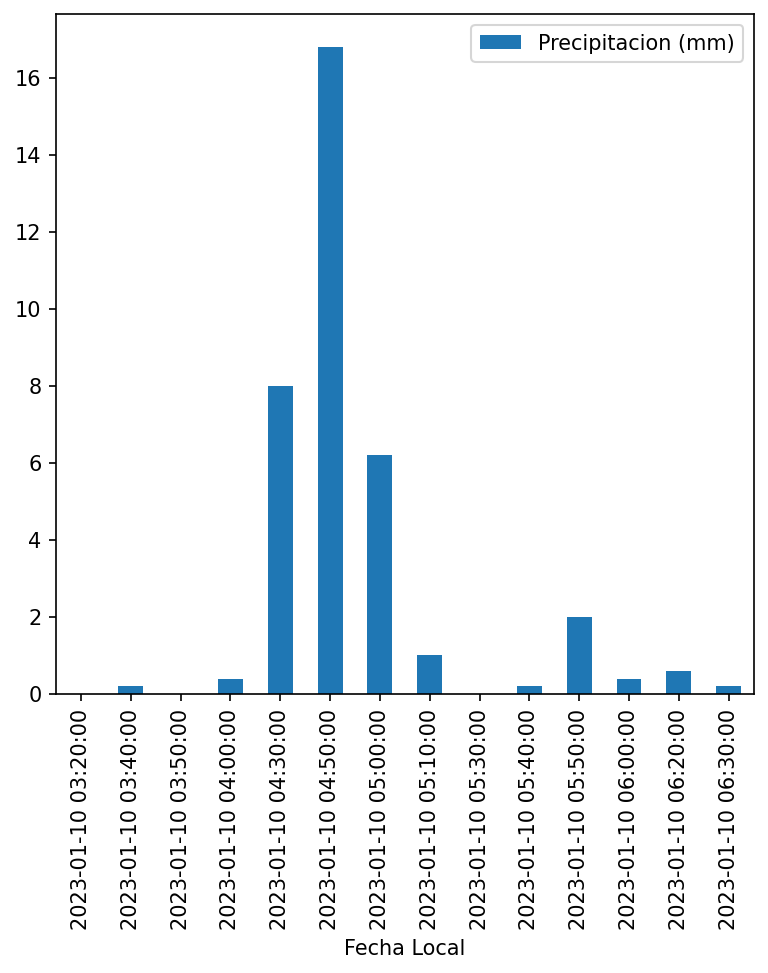

In [4]:
# Hietograma de precipitación.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos como barras.
tormenta.plot.bar(ax = ax)

In [5]:
# Calculamos el delta de tiempo.
print( tormenta.index[1] - tormenta.index[0] )
dt = 10 / 60

0 days 00:20:00


In [6]:
# Calculamos el hietograma de intensidad y la curva masa acumulada.
tormenta["Intensidad [mm/h]"] = tormenta["Precipitacion (mm)"] / dt
tormenta["Curva masa [mm]"]   = tormenta["Precipitacion (mm)"].cumsum()

tormenta

,Precipitacion (mm),Intensidad [mm/h],Curva masa [mm]
Fecha Local,,,
2023-01-10 03:20:00,0.0,0.0,0.0
2023-01-10 03:40:00,0.2,1.2,0.2
2023-01-10 03:50:00,0.0,0.0,0.2
2023-01-10 04:00:00,0.4,2.4,0.6
2023-01-10 04:30:00,8.0,48.0,8.6
2023-01-10 04:50:00,16.8,100.8,25.4
2023-01-10 05:00:00,6.2,37.2,31.6
2023-01-10 05:10:00,1.0,6.0,32.6
2023-01-10 05:30:00,0.0,0.0,32.6


<AxesSubplot:xlabel='Fecha Local'>

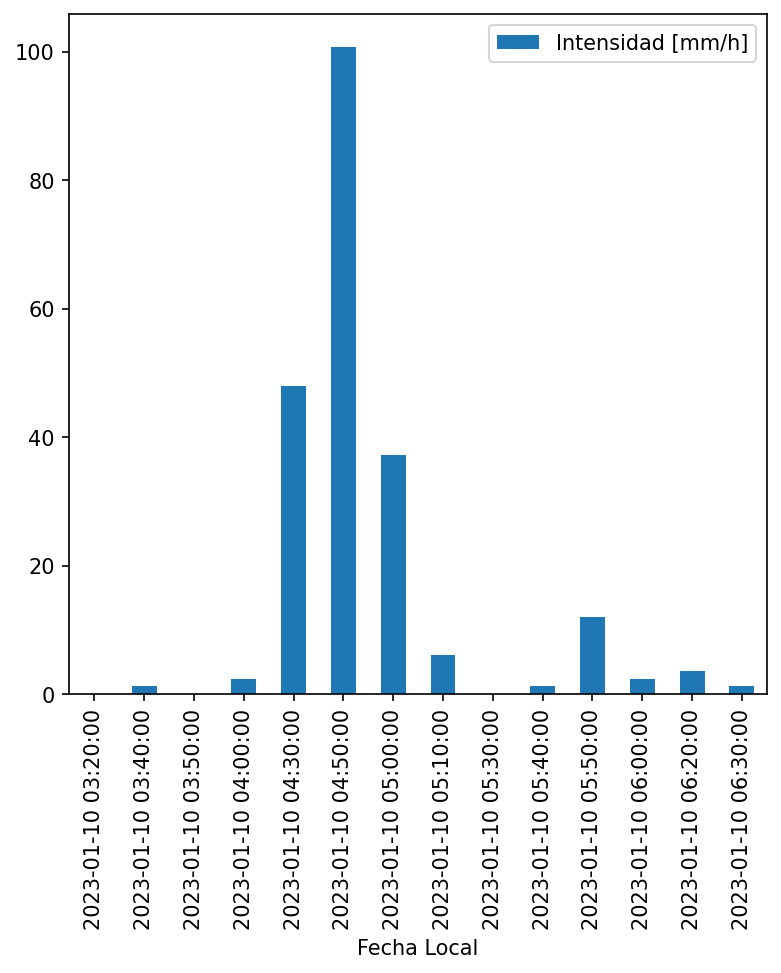

In [7]:
# Hietograma de intensidad.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Ponemos el nombre de la columna dentro de corchetes para tener un
# DataFrame y no una Serie.
tormenta[["Intensidad [mm/h]"]].plot.bar(ax = ax)

<AxesSubplot:xlabel='Fecha Local'>

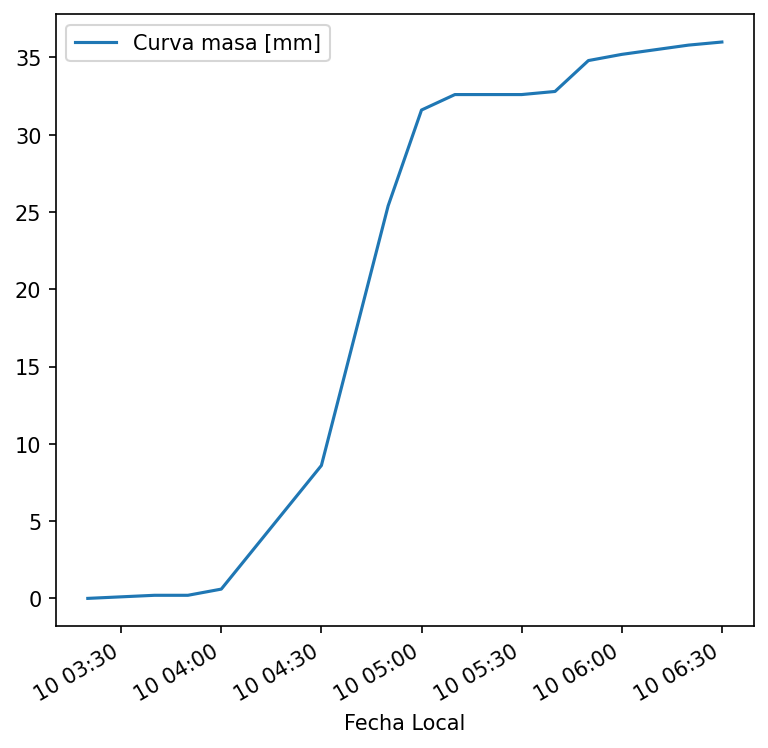

In [8]:
# Curva masa.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

tormenta[["Curva masa [mm]"]].plot(ax = ax)

In [9]:
# Duración.

# Copiamos la columna de curva masa a un nuevo dataframe.
dur = tormenta[["Curva masa [mm]"]].copy()

# Para cada duración desde dt hasta dt * cantidad de filas, la duración
# es la curva masa menos la curva masa recorrida.
for i in range( 1, dur.shape[0] ):
    dur[dt * i ] = dur["Curva masa [mm]"] - dur["Curva masa [mm]"].shift(i)

# Quitamos la columna de la curva masa.
dur.drop("Curva masa [mm]", axis = 1, inplace = True)

# Creamos un nuevo dataframe para la tabla de duración.
dur = pd.DataFrame(dur.max(axis = 0), columns = ["delta hp max"] )
dur.index.name = "Duración"

dur

,delta hp max
Duración,
0.16666666666666666,16.8
0.3333333333333333,24.8
0.5,31.0
0.6666666666666666,32.0
0.8333333333333333,32.4
1.0,32.4
1.1666666666666665,34.2
1.3333333333333333,34.6
1.5,35.2


# Regresión lineal

In [10]:
# Dirección de datos.
path_y = path + "YUCATAN/"

# Archivo con nombre de datos.
file_n = "ESTACIONES_YUCATAN.csv"

In [11]:
# Cargamos la lista de estaciones.
Estaciones = pd.read_csv(path_y + file_n)

# Creamos un punto con las coordenadas.
Estaciones["geometry"] = None
Estaciones["geometry"] = gpd.points_from_xy(
    Estaciones["LONGITUD"], Estaciones["LATITUD"])

# Creamos un GeoDataFrame.
# Las coordenadas están en WGS84 EPSG:4326.
Estaciones = gpd.GeoDataFrame(Estaciones, geometry = "geometry", crs = 4326)

# Datos
Estaciones

,ESTACION,ESTADO,LATITUD,LONGITUD,geometry
0,AKIL,YUCATAN,20.26,-89.34,POINT (-89.34000 20.26000)
1,DZAN,YUCATAN,20.39,-89.47,POINT (-89.47000 20.39000)
2,OXCUTZCAB,YUCATAN,20.30,-89.42,POINT (-89.42000 20.30000)
3,TABI,YUCATAN,20.23,-89.53,POINT (-89.53000 20.23000)
4,TEABO,YUCATAN,20.40,-89.28,POINT (-89.28000 20.40000)


In [12]:
# Graficamos.
Estaciones.explore()

In [13]:
# Cargamos la primera estación.
i = 0
precipitacion = pd.read_csv(path_y + Estaciones.loc[i, "ESTACION"] + ".csv",
    skiprows = 7, index_col = "Fecha" )
# Rename cambia el nombre de una columna o fila.
precipitacion = precipitacion.rename(
    {"Valor": Estaciones.loc[i, "ESTACION"]}, axis = 1 )

# Cargamos las siguientes estaciones y las concatenamos.
for i in range(1, Estaciones.shape[0]):
    est = pd.read_csv(path_y + Estaciones.loc[i, "ESTACION"] + ".csv",
        skiprows = 7, index_col = "Fecha" )
    est = est.rename( {"Valor": Estaciones.loc[i, "ESTACION"]}, axis = 1 )
    # Concat une dos tablas a lo largo de un eje.
    precipitacion = pd.concat( [precipitacion, est ], axis = 1)

# Escogemos solo el año.
precipitacion.index = pd.to_datetime( precipitacion.index )
precipitacion = precipitacion.sort_index()
precipitacion.index = precipitacion.index.year

precipitacion

,AKIL,DZAN,OXCUTZCAB,TABI,TEABO
Fecha,,,,,
1966,NaN,NaN,NaN,NaN,NaN
1967,NaN,1119.5,NaN,NaN,NaN
1968,NaN,949.8,NaN,NaN,NaN
1969,NaN,NaN,NaN,NaN,NaN
1970,NaN,747.5,NaN,NaN,NaN
1971,NaN,786.0,NaN,NaN,NaN
1972,NaN,1321.5,NaN,NaN,NaN
1973,NaN,1069.5,NaN,NaN,NaN
1974,NaN,1082.8,NaN,NaN,NaN


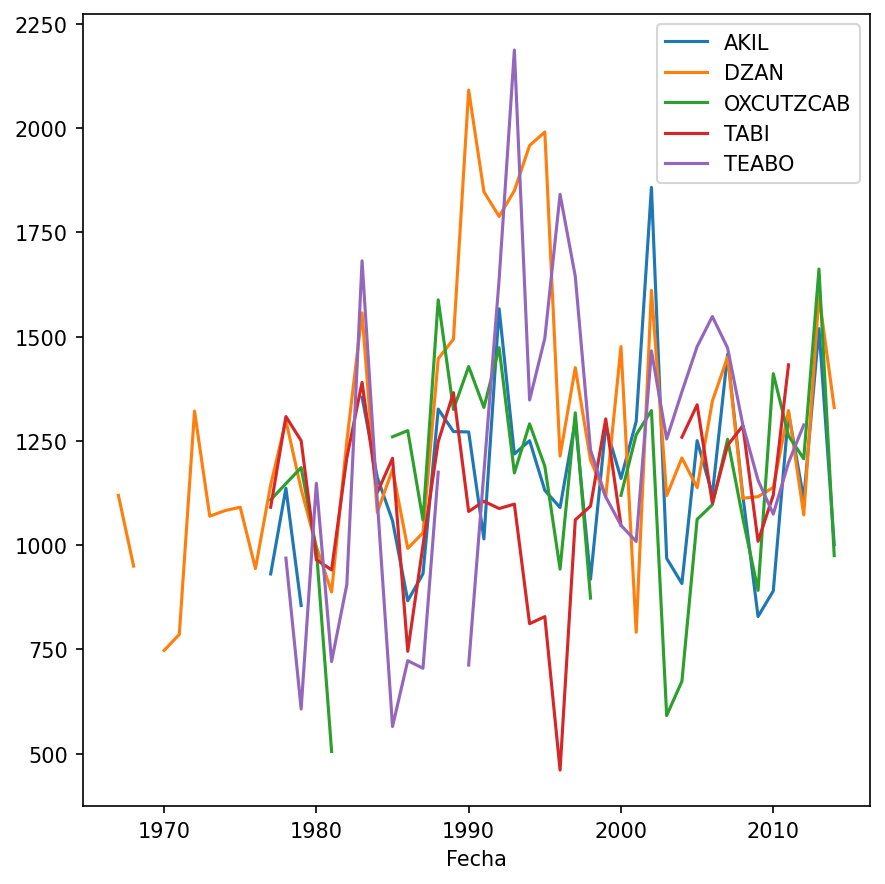

In [14]:
# Precipitación de todas las estaciones.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
precipitacion.plot(ax = ax)

fig.tight_layout()
plt.show()

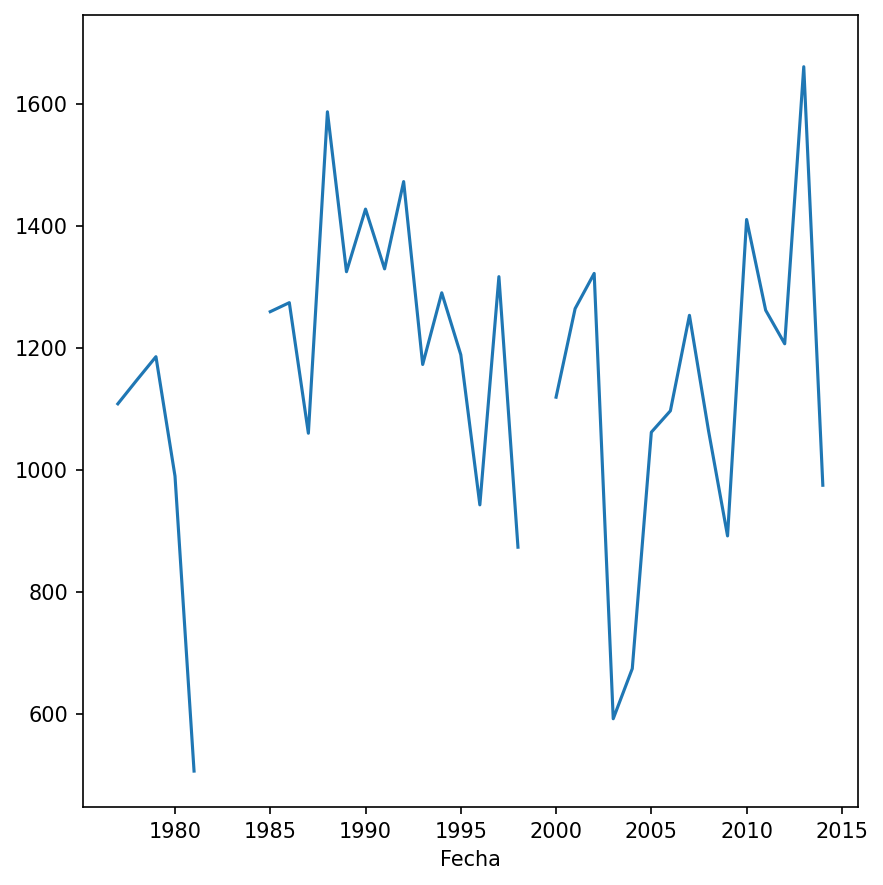

In [15]:
# Estacion Oxcutzcab.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
precipitacion["OXCUTZCAB"].plot(ax = ax)

fig.tight_layout()
plt.show()

In [16]:
# Quitamos todos los datos nulos para la regresión.
pre_reg_1 = precipitacion.dropna()
pre_reg_1

,AKIL,DZAN,OXCUTZCAB,TABI,TEABO
Fecha,,,,,
1978,1136.40,1298.6,1147.60,1308.3,969.00
1979,855.40,1134.7,1185.90,1250.4,607.30
1983,1354.70,1556.7,1687.80,1390.2,1681.70
1985,1058.50,1181.5,1259.80,1208.3,565.30
1986,866.80,992.2,1274.60,745.5,723.10
1987,931.40,1029.6,1060.20,999.7,704.80
1988,1326.20,1446.9,1588.00,1247.8,1174.90
1990,1271.30,2090.9,1428.20,1080.7,712.60
1991,1015.00,1847.3,1330.10,1105.2,1174.70


In [17]:
# Quitamos los valores nulos en los predictores
# para predecir los valores de Oxcutzcab.
pre_reg_2 = precipitacion.drop("OXCUTZCAB", axis = 1).dropna()
pre_reg_2

,AKIL,DZAN,TABI,TEABO
Fecha,,,,
1978,1136.40,1298.6,1308.3,969.00
1979,855.40,1134.7,1250.4,607.30
1983,1354.70,1556.7,1390.2,1681.70
1984,1162.80,1078.7,1126.2,1106.80
1985,1058.50,1181.5,1208.3,565.30
1986,866.80,992.2,745.5,723.10
1987,931.40,1029.6,999.7,704.80
1988,1326.20,1446.9,1247.8,1174.90
1990,1271.30,2090.9,1080.7,712.60


In [18]:
# Predictando.
Y = pre_reg_1["OXCUTZCAB"]
# Predictores.
X = pre_reg_1.drop("OXCUTZCAB", axis = 1)
# Agregamos la columna con unos
X["0"] = 1
X = X[["0"] + list( X.columns[:-1] )]

# Coeficientes de regresión.
B = np.linalg.inv( X.T @ X ) @ ( X.T @ Y )

# Para predecir necesitamos también agregar una columna de unos.
X_2 = pre_reg_2.copy()
X_2["0"] = 1
X_2 = X_2[["0"] + list( X_2.columns[:-1] )]
X_2

# Realizamos la predicción.
pre_reg_2["OXCUTZCAB"] = X_2 @ B

pre_reg_2

,AKIL,DZAN,TABI,TEABO,OXCUTZCAB
Fecha,,,,,
1978,1136.40,1298.6,1308.3,969.00,1231.187680
1979,855.40,1134.7,1250.4,607.30,1129.079225
1983,1354.70,1556.7,1390.2,1681.70,1260.990780
1984,1162.80,1078.7,1126.2,1106.80,1155.309938
1985,1058.50,1181.5,1208.3,565.30,1238.202039
1986,866.80,992.2,745.5,723.10,1045.374114
1987,931.40,1029.6,999.7,704.80,1104.678353
1988,1326.20,1446.9,1247.8,1174.90,1308.919674
1990,1271.30,2090.9,1080.7,712.60,1503.847518


<AxesSubplot:xlabel='Fecha'>

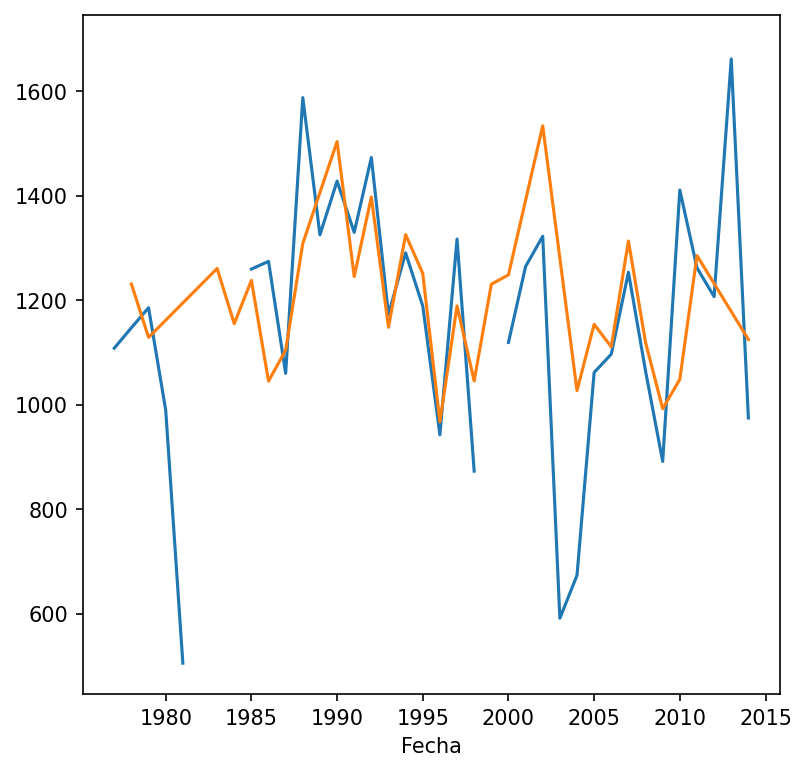

In [19]:
# Comparamos los valores reales y la predicción.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

precipitacion["OXCUTZCAB"].plot(ax = ax)
pre_reg_2["OXCUTZCAB"].plot(ax = ax)

In [20]:
# Tarea.
# Descarga la información de alguna EMA en:
# https://smn.conagua.gob.mx/tools/PHP/sivea_v2/sivea.php
# Obten la precipitación diaria con df.resample("D").sum()
# Ubica un día que haya tenido una tormenta.
# Obtén el hietograma, la curva masa y la duración.